In [75]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import esm

# takes FASTA files and generates dataframe and csv with descriptions and features

In [76]:
df = pd.read_csv("seq_df_first_10000_less_1000.csv", index_col=0).dropna()
cols = list(df.columns)
print(cols)

['Sequence', 'Name', 'Description', 'Length', 'Num_Features', 'Molecular Weight', 'Aromaticity', 'Instability Index', 'Flexibility', 'GRAVY', 'Isoelectric Point', 'Charge at pH:7.0']


In [77]:
sort_feature = "Molecular Weight"
assert sort_feature in cols, "Feature not in df.columns"
#df = df.sort_values(by=sort_feature, ascending=False)

In [78]:
df.head()

,Sequence,Name,Description,Length,Num_Features,Molecular Weight,Aromaticity,Instability Index,Flexibility,GRAVY,Isoelectric Point,Charge at pH:7.0
ID,,,,,,,,,,,,
UniRef50_A0AA42W546,TGQLQFNANGNFTYTPAPGEEGTVTFKYSITDGDGDVSEATVTITL...,UniRef50_A0AA42W546,UniRef50_A0AA42W546 Ig-like domain-containing ...,179,0,18214.3357,0.055866,19.449721,"[0.9741071428571428, 1.0226904761904763, 0.992...",-0.165363,4.050028,-22.393667
UniRef50_A0A6G3PS79,PAPGGGTRLLAYATPAAGPLAPDRLREALRTRLPDYLVPAAVIPVD...,UniRef50_A0A6G3PS79,UniRef50_A0A6G3PS79 Non-ribosomal peptide synt...,368,0,39696.4009,0.057065,49.930435,"[1.019547619047619, 1.0032142857142856, 1.0022...",-0.179348,5.741045,-9.655422
UniRef50_A0A351Y3E2,MQFSNDDITRSSREAFATTKAWTLSAGTGTKTVYANFDTDNNTATI...,UniRef50_A0A351Y3E2,UniRef50_A0A351Y3E2 Uncharacterized protein n=...,94,0,9975.6989,0.085106,20.857447,"[1.023142857142857, 1.0224999999999997, 0.9933...",-0.148936,4.050028,-11.512483
UniRef50_A0A6J0CV59,MKRAKHLSTTSKKLTSVPELPFKKGLLNSSPKLKEKRNTKPLHDKT...,UniRef50_A0A6J0CV59,UniRef50_A0A6J0CV59 Coiled-coil domain-contain...,91,0,10300.0842,0.021978,57.538462,"[0.9833809523809524, 1.002047619047619, 1.0209...",-0.775824,10.326820,11.766058
UniRef50_A0A0R1E8D2,MGGKHQGSGAGVSSGGGSLNSSLCNSVVTSATTASSSLTQQQQQLQ...,UniRef50_A0A0R1E8D2,UniRef50_A0A0R1E8D2 Drosophila melanogaster (F...,142,0,15366.3947,0.105634,44.885211,"[1.041547619047619, 1.0264642857142856, 1.0294...",0.128873,9.596329,5.998322


### Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of GRAVY values')

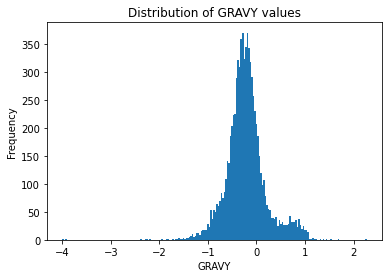

In [55]:
plt.hist(df["GRAVY"], bins=200)
plt.xlabel("GRAVY")
plt.ylabel("Frequency")
plt.title("Distribution of GRAVY values")

Text(0.5, 1.0, 'Distribution of Aromaticity values')

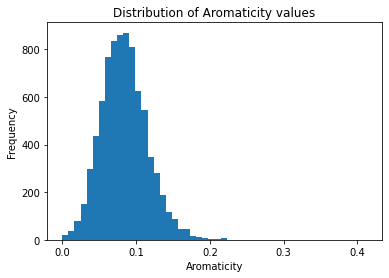

In [56]:
plt.hist(df["Aromaticity"], bins=50)
plt.xlabel("Aromaticity")
plt.ylabel("Frequency")
plt.title("Distribution of Aromaticity values")

Text(0.5, 1.0, 'Distribution of MW values')

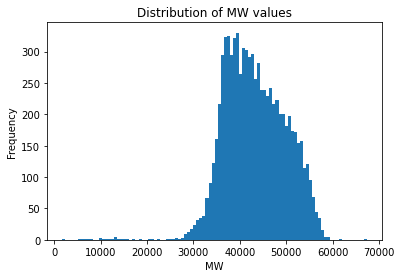

In [57]:
plt.hist(df["Molecular Weight"], bins=100)
plt.xlabel("MW")
plt.ylabel("Frequency")
plt.title("Distribution of MW values")

Text(0.5, 1.0, 'Distribution of Charge at pH:7.0 values')

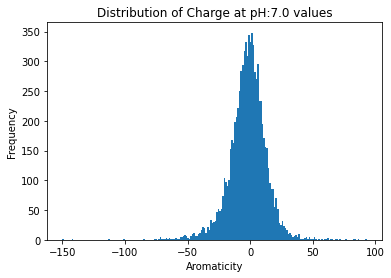

In [58]:
plt.hist(df["Charge at pH:7.0"], bins=200)
plt.xlabel("Aromaticity")
plt.ylabel("Frequency")
plt.title("Distribution of Charge at pH:7.0 values")

### Load Model

In [59]:
# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
#model, alphabet = esm.pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

ESM2(
  (embed_tokens): Embedding(33, 320, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (q_proj): Linear(in_features=320, out_features=320, bias=True)
        (out_proj): Linear(in_features=320, out_features=320, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=320, out_features=1280, bias=True)
      (fc2): Linear(in_features=1280, out_features=320, bias=True)
      (final_layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=320, out_features=320, bias=True)
        (v_proj): Linear(in_features=320, out_features=320, bias=True)
        (

In [61]:
def get_features(data, model):    
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[6], return_contacts=True)
    token_representations = results["representations"][6]
    results["token_representations"] = token_representations
    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0).numpy())
    results['sequence_representations'] = torch.tensor(np.array(sequence_representations)) # first to np for speed-up
    # Look at the unsupervised self-attention map contact predictions
    # import matplotlib.pyplot as plt
    # for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    #     plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    #     plt.title(seq[:10] + "...")
    #     plt.colorbar()
    #     plt.show()    
    return results

In [ ]:
top_gravy = df.iloc[:10]
low_gravy = df.iloc[-10:]

top_gravy_X = [(top_gravy.iloc[i]["Name"], top_gravy.iloc[i]["Sequence"]) for i in range(len(top_gravy))]
low_gravy_X = [(low_gravy.iloc[i]["Name"], low_gravy.iloc[i]["Sequence"]) for i in range(len(low_gravy))]
top_gravy_X, low_gravy_X

In [ ]:
# this can take a while...
top_gravy_results = get_features(top_gravy_X, model)
low_gravy_results = get_features(low_gravy_X, model)

In [ ]:
res_high = dict(top_gravy_results)
print(res_high.keys())
res_low = dict(low_gravy_results)
print(res_low.keys())

In [ ]:
sr_high = res_high['sequence_representations'] # top feature representations
plt.imshow(sr_high)

In [ ]:
sr_low = res_low['sequence_representations'] # top feature representations
plt.imshow(sr_low)

### Visuals

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
sr_high = sr_high[:]
sr_high_std = sr_high - sr_high.mean(axis=0)
sr_high_std /= sr_high_std.std(axis=0)

sr_low = sr_low[:]
sr_low_std = sr_low - sr_low.mean(axis=0)
sr_low_std /= sr_low_std.std(axis=0)

In [ ]:
pca = PCA(n_components=3)

sr_high_pca = pca.fit_transform(sr_high_std)
sr_low_pca = pca.fit_transform(sr_low_std)

In [ ]:
plt.scatter(sr_high_pca[:, 0], sr_high_pca[:, 1])
plt.scatter(sr_low_pca[:, 0], sr_low_pca[:, 1])

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection="3d")

# 3-D scatter for the two classes
ax.scatter(
    sr_high_pca[:, 0], sr_high_pca[:, 1], sr_high_pca[:, 2],
    s=20, alpha=0.7, label="high SR", marker="o"
)
ax.scatter(
    sr_low_pca[:, 0], sr_low_pca[:, 1], sr_low_pca[:, 2],
    s=20, alpha=0.7, label="low SR",  marker="^"
)

# Axis labels (use real explained-variance % if you have pca.explained_variance_ratio_)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

ax.legend(loc="best")
ax.set_title("3-D PCA projection")
plt.tight_layout(); plt.show()

In [ ]:
tsne = TSNE(
    n_components     = 3,      # 2-D for plotting (use 3 for 3-D)
    perplexity       = 1,     # “effective #neighbors” (5–50 typical)
    learning_rate    = "auto", # or a value ~ n_samples / 12
    init             = "pca",  # pca|random; pca gives stabler layouts
    n_iter           = 2000,   # 250–1000 is common; more for cleaner structure
    metric           = "euclidean",
    random_state     = 0,
    verbose          = 1
)
Z = tsne.fit_transform(sr_high_std)    
Z_2 = tsne.fit_transform(sr_low_std) # shape (n_samples, 2)

# 4) Visualise  ---------------------------------------------------------
plt.scatter(Z[:,0], Z[:,1], s=10, alpha=0.7)
plt.scatter(Z_2[:,0], Z_2[:,1], s=10, alpha=0.7)
plt.title("t-SNE projection"); plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2"); plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection="3d")

# 3-D scatter for the two classes
ax.scatter(
    Z[:, 0], Z[:, 1], Z[:, 2],
    s=20, alpha=0.7, label="high SR", marker="o"
)
ax.scatter(
    Z_2[:, 0], Z_2[:, 1], Z_2[:, 2],
    s=20, alpha=0.7, label="low SR",  marker="^"
)

# Axis labels (use real explained-variance % if you have pca.explained_variance_ratio_)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

ax.legend(loc="best")
ax.set_title("3-D PCA projection")
plt.tight_layout(); plt.show()

In [62]:
# for each sample, calculate representation
out_cols = ["Name", "Sequence", "Token Representations", "Sequence Representations", "Contacts"]
outputs = [] # stores rows with name, sequence as strings and representations and contacts urls

In [69]:
df = df.sample(frac=1)

In [70]:
import tqdm

In [71]:
# unbatched
output_path = "model_outputs_8M/sample_output/"

for row in tqdm.tqdm(df[["Name", "Sequence"]].itertuples()):
    batch = [
        (row.Name, row.Sequence)
        ]
    res = get_features(batch, model)
    # generate paths
    token_representations_path = output_path + "token_representations/" + str(row.Name) + ".pt"
    sequence_representations_path = output_path + "sequence_representations/" + str(row.Name) + ".pt"
    contacts_path = output_path + "contacts/" + str(row.Name) + ".pt"
    # save tensors as .pt
    torch.save(res['token_representations'][0], token_representations_path) # uses index 0 due to being unbatched
    torch.save(res['sequence_representations'][0], sequence_representations_path)
    torch.save(res['contacts'][0], contacts_path)
    # save urls to list for csv
    outputs.append([row.Name, row.Sequence, token_representations_path, sequence_representations_path, contacts_path])

1645it [06:57,  3.94it/s]


KeyboardInterrupt: 

In [72]:
out_df = pd.DataFrame(outputs[0:], columns=out_cols)

In [73]:
out_df

,Name,Sequence,Token Representations,Sequence Representations,Contacts
0,UniRef50_A0A1D8AY05,MADPLDPRLDSLAEVIVRVGLNLQPGQPLLITDPYELQGVHPETAA...,model_outputs_8M/sample_output/token_represent...,model_outputs_8M/sample_output/sequence_repres...,model_outputs_8M/sample_output/contacts/UniRef...
1,UniRef50_T0ST41,MNQLTLGAIFILAIGAFTSISIMSGFHIFISIPSLFFAFKSRLKKT...,model_outputs_8M/sample_output/token_represent...,model_outputs_8M/sample_output/sequence_repres...,model_outputs_8M/sample_output/contacts/UniRef...
2,UniRef50_A0A0G2A7B9,MSLKIKLALYIGLGIVVVFAVLLVTGVIKPFQPETIKGDIVVWDKD...,model_outputs_8M/sample_output/token_represent...,model_outputs_8M/sample_output/sequence_repres...,model_outputs_8M/sample_output/contacts/UniRef...
3,UniRef50_Q0V391,MSPPRRDIMSHMSNRPSSSRSRGPAPKIVVKKEPNSPDMPTTTRHR...,model_outputs_8M/sample_output/token_represent...,model_outputs_8M/sample_output/sequence_repres...,model_outputs_8M/sample_output/contacts/UniRef...
4,UniRef50_UPI002251E226,MDNNGNQLIQVERVVEINERDILVGDFMISLIVENRSSIIYPSYRH...,model_outputs_8M/sample_output/token_represent...,model_outputs_8M/sample_output/sequence_repres...,model_outputs_8M/sample_output/contacts/UniRef...
...,...,...,...,...,...
1640,UniRef50_A0A7W9W9L3,MKVNSLWTPTRRELFIASGASLLAGCGGSSPSPNPTPTPTPAPTPT...,model_outputs_8M/sample_output/token_represent...,model_outputs_8M/sample_output/sequence_repres...,model_outputs_8M/sample_output/contacts/UniRef...
1641,UniRef50_A0A1S2LH12,MISDLIVNIAVLTSFTFFWHQALKNNRLTLNSRTKIKILDGIIGGV...,model_outputs_8M/sample_output/token_represent...,model_outputs_8M/sample_output/sequence_repres...,model_outputs_8M/sample_output/contacts/UniRef...
1642,UniRef50_A0A210QWA1,MVPKEHSESTVLTITSASEEDYGTYDVIVSNDGGQAVIPVKLTVHE...,model_outputs_8M/sample_output/token_represent...,model_outputs_8M/sample_output/sequence_repres...,model_outputs_8M/sample_output/contacts/UniRef...
1643,UniRef50_UPI00254AAAC8,MNNLVDIKEWEQKRKTTFFVYMLLYFFAEFEKSINTATLWFYLTKL...,model_outputs_8M/sample_output/token_represent...,model_outputs_8M/sample_output/sequence_repres...,model_outputs_8M/sample_output/contacts/UniRef...


In [74]:
# save csv
out_df.to_csv("model_outputs_8M/UniRef50_n1645.csv")